In [62]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white
from statsmodels.regression.linear_model import OLS
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(12435)


In [44]:
# Load datasets
evs = pd.read_csv('data/replication_archive/tables/EVS_main.csv')
evs_weimar = pd.read_csv('data/replication_archive/tables/evs_weimar.csv')
elections = pd.read_csv('data/replication_archive/tables/elections_2017.csv')

print(f"EVS Main Dataset: {evs.shape[0]} observations, {evs.shape[1]} variables")
print(f"EVS Weimar Dataset: {evs_weimar.shape[0]} observations, {evs_weimar.shape[1]} variables")
print(f"2017 Elections Dataset: {elections.shape[0]} observations, {elections.shape[1]} variables")
print("\nEVS Main - First few rows:")

# Recode state names for better display
state_names = {
    'DE1': 'WEST:\nBaden-Wurttemberg',
    'DE2': 'WEST:\nBavaria',
    'DE3': 'EAST:\nBerlin',
    'DE4': 'EAST:\nBrandenburg',
    'DE5': 'WEST:\nBremen',
    'DE6': 'WEST:\nHamburg',
    'DE7': 'WEST:\nHessen',
    'DE8': 'EAST:\nMecklenburg-Vorpommern',
    'DE9': 'WEST:\nLower Saxony',
    'DEA': 'WEST:\nNorth Rhine-Westphalia',
    'DEB': 'WEST:\nRhineland Palatinate',
    'DEC': 'WEST:\nSaarland',
    'DED': 'EAST:\nSaxony',
    'DEE': 'EAST:\nSaxony-Anhalt',
    'DEF': 'WEST:\nSchleswig-Holstein',
    'DEG': 'EAST:\nThuringia'
}

evs['state_name'] = evs['state'].map(state_names)
evs['f_state'] = evs['state'].astype('category')

# Summary statistics by state
print("Mean Intolerance by State:")
state_summary = evs.groupby('state_name')['intolerance'].agg(['mean', 'count'])
state_summary.sort_values('mean', ascending=False)
evs.head()

EVS Main Dataset: 2075 observations, 20 variables
EVS Weimar Dataset: 2052 observations, 77 variables
2017 Elections Dataset: 11302 observations, 37 variables

EVS Main - First few rows:
Mean Intolerance by State:


,kreise,Distance,closest_camp,unemp,educ,west,female,age,urban_scale,lr,...,prop_jewish25,unemployment33,population25,nazishare33,intolerance,resentment,far_right,state,state_name,f_state
0,-,15.969231,Neuengamme,0.0,5.0,1,0,63.0,6,5.0,...,0.000966,0.129652,0.596945,0.485495,-0.378253,5.883597,0,DEF,WEST:\nSchleswig-Holstein,DEF
1,-,15.969231,Neuengamme,0.0,5.0,1,0,49.0,6,NaN,...,0.000966,0.129652,0.596945,0.485495,0.898075,-2.047545,0,DEF,WEST:\nSchleswig-Holstein,DEF
2,-,15.969231,Neuengamme,1.0,8.0,1,1,28.0,6,NaN,...,0.000966,0.129652,0.596945,0.485495,-0.378253,-5.604500,0,DEF,WEST:\nSchleswig-Holstein,DEF
3,-,15.969231,Neuengamme,1.0,5.0,1,1,53.0,6,5.0,...,0.000966,0.129652,0.596945,0.485495,0.348260,5.711561,0,DEF,WEST:\nSchleswig-Holstein,DEF
4,-,15.969231,Neuengamme,0.0,5.0,1,0,72.0,6,7.0,...,0.000966,0.129652,0.596945,0.485495,0.396214,3.275474,0,DEF,WEST:\nSchleswig-Holstein,DEF


In [59]:
# basic linear regression with statmodels
model = smf.ols('intolerance ~ age + female', data=evs).fit()
print("\nOLS Regression Results:")
print(model.summary())


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:            intolerance   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.637
Date:                 Di, 09 Dez 2025   Prob (F-statistic):            0.00979
Time:                        14:37:45   Log-Likelihood:                -2159.8
No. Observations:                2075   AIC:                             4326.
Df Residuals:                    2072   BIC:                             4343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0971      

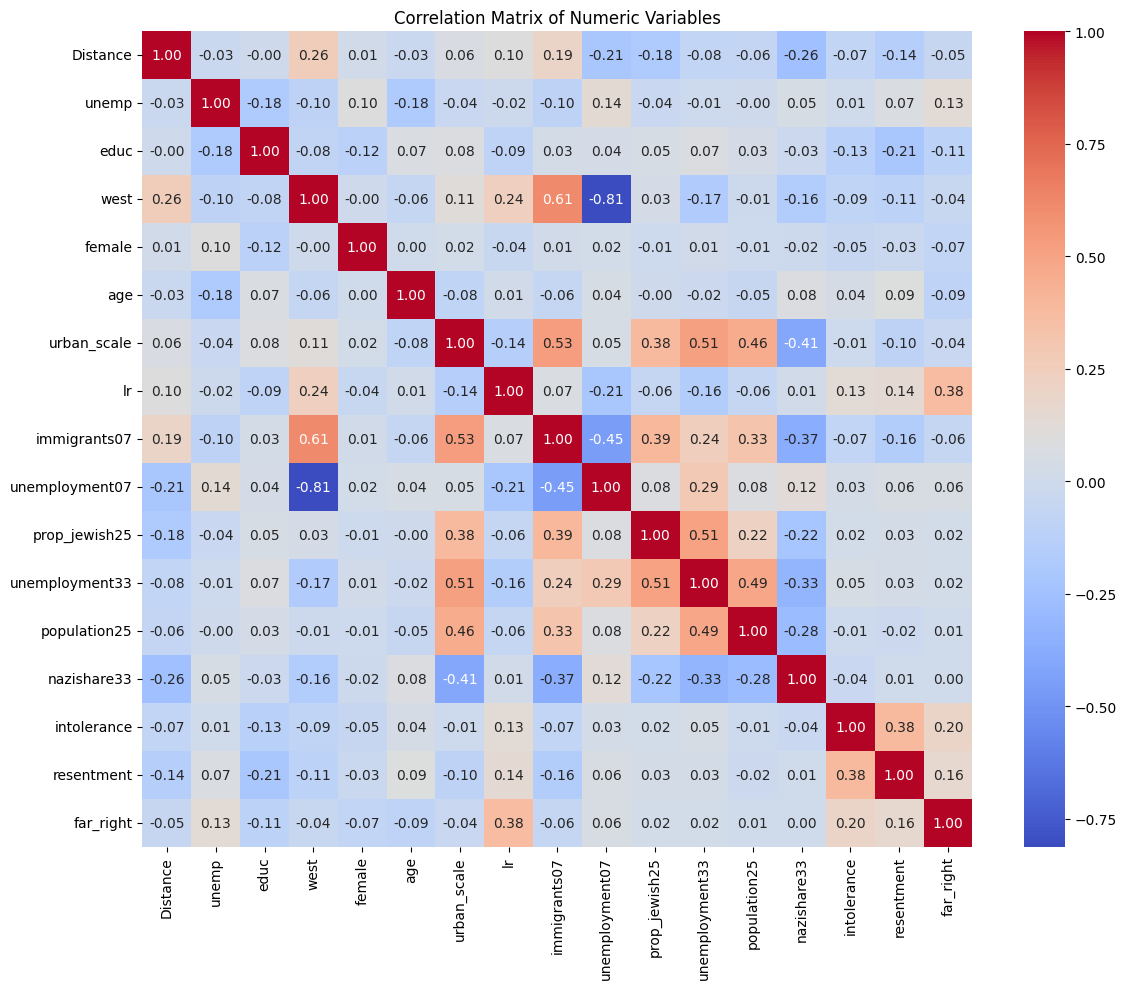

In [32]:
# corrplot from numeric values
numeric_cols = evs.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

In [ ]:
# generate dicts for y and X variables and controls
y = {
    'intolerance': 'Intolerance Score'
}
X = {
    'urban_scale': 'Distance to Nearest Border (km)',
    'age': 'Age',
    'female': 'Female (1=Yes)',
}
controls = {
}
# do train test split
X_train, X_test, y_train, y_test = train_test_split(evs[list(X.keys())], evs[y.keys()], test_size=0.2, random_state=42)
# scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# define dict for sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
models = {
    'OLS': LinearRegression(),
    'RF-Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
  #  'Logistic Regression': LogisticRegression(max_iter=1000),
    'Simple desicion tree': DecisionTreeRegressor(random_state=42),
    'SVM': SVR(kernel='linear'),
}


# fit models
for model_name, model in models.items():
    # Prepare data
    features = list(X.keys()) + list(controls.keys())
    X_data = evs[features].dropna()
    y_data = evs.loc[X_data.index, 'intolerance']

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MSE: {mse:.3f}, R²: {r2:.3f}")

OLS - MSE: 0.559, R²: -0.011
RF-Regressor - MSE: 0.765, R²: -0.384
Gradient boosting - MSE: 0.579, R²: -0.048
Ridge Regression - MSE: 0.559, R²: -0.011
Lasso Regression - MSE: 0.557, R²: -0.007
Simple desicion tree - MSE: 0.915, R²: -0.655
SVM - MSE: 0.775, R²: -0.401


In [54]:
from collections.abc import Sequence
from typing import Dict, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.base import RegressorMixin
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
    root_mean_squared_error,
)
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson, jarque_bera

ModelInput = Union[
    RegressorMixin,
    Sequence[Tuple[str, RegressorMixin]],
]


def regression_evaluation(
    models: ModelInput,
    X_test,
    y_test,
    *,
    title: str | None = None,
) -> Dict[str, Dict[str, float]]:
    """Evaluate fitted regressors, plot diagnostics, and summarize metrics."""
    if hasattr(X_test, "columns"):
        feature_names = list(X_test.columns)
        X = np.asarray(X_test.to_numpy())
    else:
        X = np.asarray(X_test)
        feature_names = []
    y = np.asarray(y_test)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if not feature_names:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]

    if isinstance(models, Sequence) and not isinstance(models, RegressorMixin):
        named_models = list(models)
    else:
        named_models = [("model", models)]

    results: Dict[str, Dict[str, float]] = {}
    scalar_metrics: Dict[str, Dict[str, float]] = {}
    feature_importances: Dict[str, np.ndarray | None] = {}
    colors = sns.color_palette("tab10", len(named_models))
    color_map: Dict[str, Tuple[float, float, float]] = {}

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    if title:
        fig.suptitle(title)

    cooks_fig, cooks_ax = plt.subplots(figsize=(9, 4))
    qq_quantiles = stats.norm.ppf((np.arange(1, X.shape[0] + 1) - 0.5) / X.shape[0])
    diag_min = y.min()
    diag_max = y.max()

    for idx, (name, model) in enumerate(named_models):
        y_pred = model.predict(X)
        residuals = y - y_pred
        n, p = X.shape

        diag_min = min(diag_min, y_pred.min())
        diag_max = max(diag_max, y_pred.max())

        adj_r2 = 1 - (1 - r2_score(y, y_pred)) * (n - 1) / max(n - p - 1, 1)
        X_design = np.c_[np.ones(n), X]
        lm_stat, lm_pvalue, _, _ = het_breuschpagan(residuals, X_design)
        dw = durbin_watson(residuals)
        jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
        vif = [variance_inflation_factor(X, j) for j in range(p)]

        metrics = {
            "r2": r2_score(y, y_pred),
            "adj_r2": adj_r2,
            "explained_variance": explained_variance_score(y, y_pred),
            "rmse": root_mean_squared_error(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
            "medae": median_absolute_error(y, y_pred),
            "mape": mean_absolute_percentage_error(y, y_pred),
            "breusch_pagan_stat": lm_stat,
            "breusch_pagan_p": lm_pvalue,
            "durbin_watson": dw,
            "jarque_bera_stat": jb_stat,
            "jarque_bera_p": jb_pvalue,
            "vif": dict(enumerate(vif)),
        }
        results[name] = metrics
        scalar_metrics[name] = {k: v for k, v in metrics.items() if np.isscalar(v)}

        XtX_inv = np.linalg.pinv(X_design.T @ X_design)
        leverage = np.einsum("ij,jk,ik->i", X_design, XtX_inv, X_design)
        residual_var = np.maximum(np.mean(residuals**2), 1e-8)
        denom = np.sqrt(np.maximum(1 - leverage, 1e-8)) * np.sqrt(residual_var)
        std_res = residuals / denom
        scale_loc = np.sqrt(np.abs(std_res))
        cooks_d = (std_res**2 * leverage) / ((p + 1) * np.maximum(1 - leverage, 1e-8))

        color = colors[idx % len(colors)]
        color_map[name] = color
        sns.kdeplot(residuals, ax=axes[0, 0], label=name, color=color)
        axes[0, 1].scatter(y_pred, residuals, s=25, alpha=0.75, color=color, label=name)
        axes[0, 2].scatter(y, y_pred, s=25, alpha=0.75, color=color, label=name)

        res_std = np.std(residuals, ddof=1)
        ordered_res = np.sort((residuals - residuals.mean()) / max(res_std, 1e-8))
        axes[1, 0].scatter(qq_quantiles, ordered_res, s=20, alpha=0.75, color=color, label=name)
        axes[1, 1].scatter(y_pred, scale_loc, s=25, alpha=0.75, color=color, label=name)
        axes[1, 2].scatter(leverage, std_res, s=25, alpha=0.75, color=color, label=name)

        markerline, stemlines, baseline = cooks_ax.stem(
            range(len(cooks_d)),
            cooks_d,
            linefmt="-",
            markerfmt="o",
            basefmt=" ",
        )
        plt.setp(markerline, color=color)
        plt.setp(stemlines, color=color)
        markerline.set_label(name)

        importance = None
        if hasattr(model, "feature_importances_"):
            importance = np.asarray(model.feature_importances_, dtype=float)
        elif hasattr(model, "coef_"):
            coef = np.asarray(model.coef_, dtype=float)
            if coef.ndim > 1:
                coef = coef.ravel()
            importance = np.abs(coef)
        if importance is not None and importance.size == X.shape[1]:
            feature_importances[name] = importance
        else:
            feature_importances[name] = None

    axes[0, 0].set(title="Residual KDEs", xlabel="Residual")
    axes[0, 1].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[0, 1].set(title="Residuals vs Predicted", xlabel="Predicted", ylabel="Residual")
    axes[0, 2].plot([diag_min, diag_max], [diag_min, diag_max], "--", color="black", linewidth=1)
    axes[0, 2].set(title="Actual vs Predicted", xlabel="Actual", ylabel="Predicted")
    axes[0, 0].legend()
    axes[0, 1].legend()
    axes[0, 2].legend()

    min_lim = min(axes[1, 0].get_xlim()[0], axes[1, 0].get_ylim()[0])
    max_lim = max(axes[1, 0].get_xlim()[1], axes[1, 0].get_ylim()[1])
    axes[1, 0].plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)
    axes[1, 0].set(xlabel="Theoretical quantiles", ylabel="Ordered values", title="Normal Q-Q Plot")
    axes[1, 0].legend()
    axes[1, 1].set(title="Scale-Location", xlabel="Predicted", ylabel="sqrt(|std residual|)")
    axes[1, 1].legend()
    axes[1, 2].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[1, 2].set(title="Residuals vs Leverage", xlabel="Leverage", ylabel="Std Residual")
    axes[1, 2].legend()

    fig.tight_layout()
    plt.show()

    cooks_ax.axhline(4 / max(X.shape[0] - X.shape[1] - 1, 1), color="red", linestyle="--", linewidth=1)
    cooks_ax.set(title="Cook's Distance", xlabel="Observation", ylabel="Cook's D")
    cooks_ax.legend()
    cooks_fig.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame.from_dict(scalar_metrics, orient="index")
    if not metrics_df.empty:
        if "rmse" in metrics_df.columns:
            metrics_df = metrics_df.sort_values("rmse")
        fig_table, ax_table = plt.subplots(figsize=(1.5 * metrics_df.shape[1], 0.6 * metrics_df.shape[0] + 2))
        normalized_df = metrics_df.copy()
        for col in normalized_df.columns:
            col_min = normalized_df[col].min()
            col_max = normalized_df[col].max()
            if not np.isfinite(col_min) or not np.isfinite(col_max) or abs(col_max - col_min) < 1e-12:
                normalized_df[col] = 0.5
            else:
                normalized_df[col] = (normalized_df[col] - col_min) / (col_max - col_min)
        sns.heatmap(
            normalized_df,
            annot=metrics_df.round(3),
            fmt="",
            cmap="YlGnBu",
            cbar=True,
            ax=ax_table,
        )
        ax_table.set_title("Model Metrics (column-normalized colors)")
        plt.tight_layout()
        plt.show()

        metric_directions = {
            "adj_r2": "max",
            "explained_variance": "max",
            "rmse": "min",
            "mae": "min",
            "mape": "min",
            "breusch_pagan_p": "max",
            "durbin_watson": ("target", 2.0),
            "jarque_bera_p": "max",
            "r2": "max",
        }
        radar_metrics = [col for col in metrics_df.columns if col in metric_directions]
        if radar_metrics:
            radar_df = metrics_df[radar_metrics].copy().astype(float)
            radar_norm = pd.DataFrame(index=radar_df.index, columns=radar_metrics, dtype=float)
            for col in radar_metrics:
                directive = metric_directions[col]
                values = radar_df[col]
                finite_mask = np.isfinite(values)
                if not finite_mask.any():
                    radar_norm[col] = 0.5
                    continue
                vals = values[finite_mask]
                if isinstance(directive, tuple) and directive[0] == "target":
                    target = directive[1]
                    diff = np.abs(vals - target)
                    diff_min = diff.min()
                    diff_max = diff.max()
                    if abs(diff_max - diff_min) < 1e-12:
                        normalized = pd.Series(1.0, index=values.index)
                    else:
                        normalized = 1 - (np.abs(values - target) - diff_min) / (diff_max - diff_min)
                else:
                    col_min = vals.min()
                    col_max = vals.max()
                    direction = directive
                    if abs(col_max - col_min) < 1e-12:
                        normalized = pd.Series(1.0, index=values.index)
                    elif direction == "max":
                        normalized = (values - col_min) / (col_max - col_min)
                    else:
                        normalized = (col_max - values) / (col_max - col_min)
                normalized = normalized.clip(0, 1).fillna(0.5)
                radar_norm[col] = normalized

            angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
            angles += angles[:1]
            fig_radar = plt.figure(figsize=(7, 7))
            ax_radar = fig_radar.add_subplot(111, polar=True)
            for model_name, row in radar_norm.iterrows():
                values = row.tolist()
                values += values[:1]
                color = color_map.get(model_name, None)
                ax_radar.plot(angles, values, label=model_name, color=color)
                ax_radar.fill(angles, values, alpha=0.1, color=color)
            ax_radar.set_xticks(angles[:-1])
            ax_radar.set_xticklabels(radar_metrics)
            ax_radar.set_ylim(0, 1)
            ax_radar.set_yticks([0.25, 0.5, 0.75, 1.0])
            ax_radar.set_yticklabels(["0.25", "0.5", "0.75", "1.0"])
            ax_radar.set_title("Model Metrics Radar (outer = better)")
            ax_radar.legend(loc="upper right", bbox_to_anchor=(1.25, 1.15))
            fig_radar.tight_layout()
            plt.show()

    valid_importances = {k: v for k, v in feature_importances.items() if v is not None}
    if valid_importances:
        normalized_importances = {}
        for model_name, importance in valid_importances.items():
            denom = np.max(importance) if importance.size else 0.0
            if not np.isfinite(denom) or denom < 1e-12:
                normalized_importances[model_name] = np.zeros_like(importance, dtype=float)
            else:
                normalized_importances[model_name] = importance / denom

        reference_model = None
        for ref_name, _ in named_models:
            if ref_name in normalized_importances:
                reference_model = ref_name
                break
        if reference_model is None:
            reference_model = next(iter(normalized_importances))
        ref_imp = normalized_importances[reference_model]
        order_idx = np.argsort(ref_imp)[::-1]
        feature_order = [feature_names[i] for i in order_idx]

        fi_rows = []
        for model_name, importance in normalized_importances.items():
            rows = pd.DataFrame({
                "feature": feature_names[: importance.size],
                "importance": importance,
                "model": model_name,
            })
            fi_rows.append(rows)
        fi_df = pd.concat(fi_rows, ignore_index=True)
        fi_df = fi_df[fi_df["feature"].isin(feature_order)]
        fi_df["feature"] = pd.Categorical(fi_df["feature"], categories=feature_order, ordered=True)
        plt.figure(figsize=(10, max(4, len(feature_order) * 0.4)))
        sns.barplot(data=fi_df, y="feature", x="importance", hue="model")
        plt.title("Normalized Feature Importance by Model")
        plt.xlabel("Normalized importance (per model)")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    return {"metrics": results, "metrics_table": metrics_df}




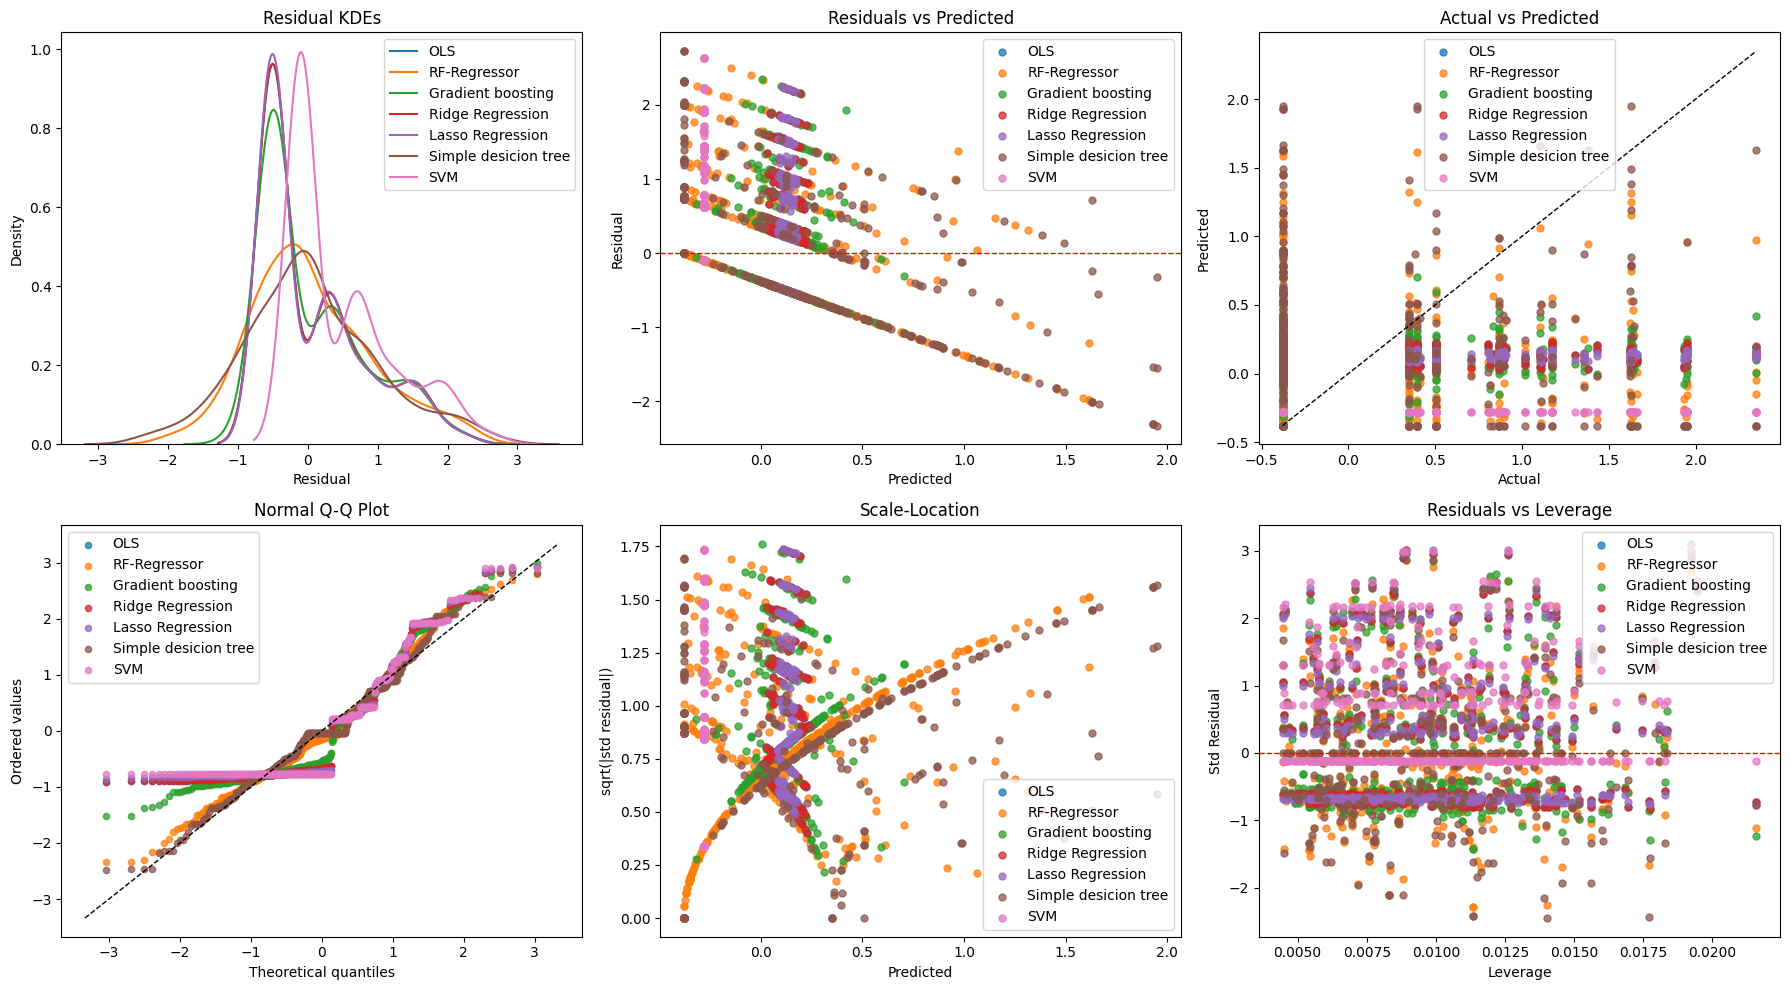

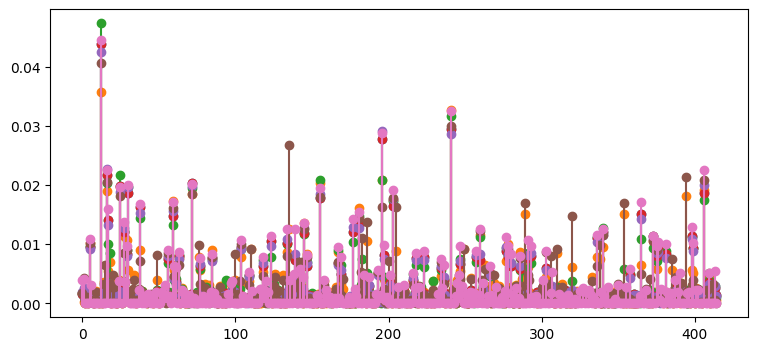

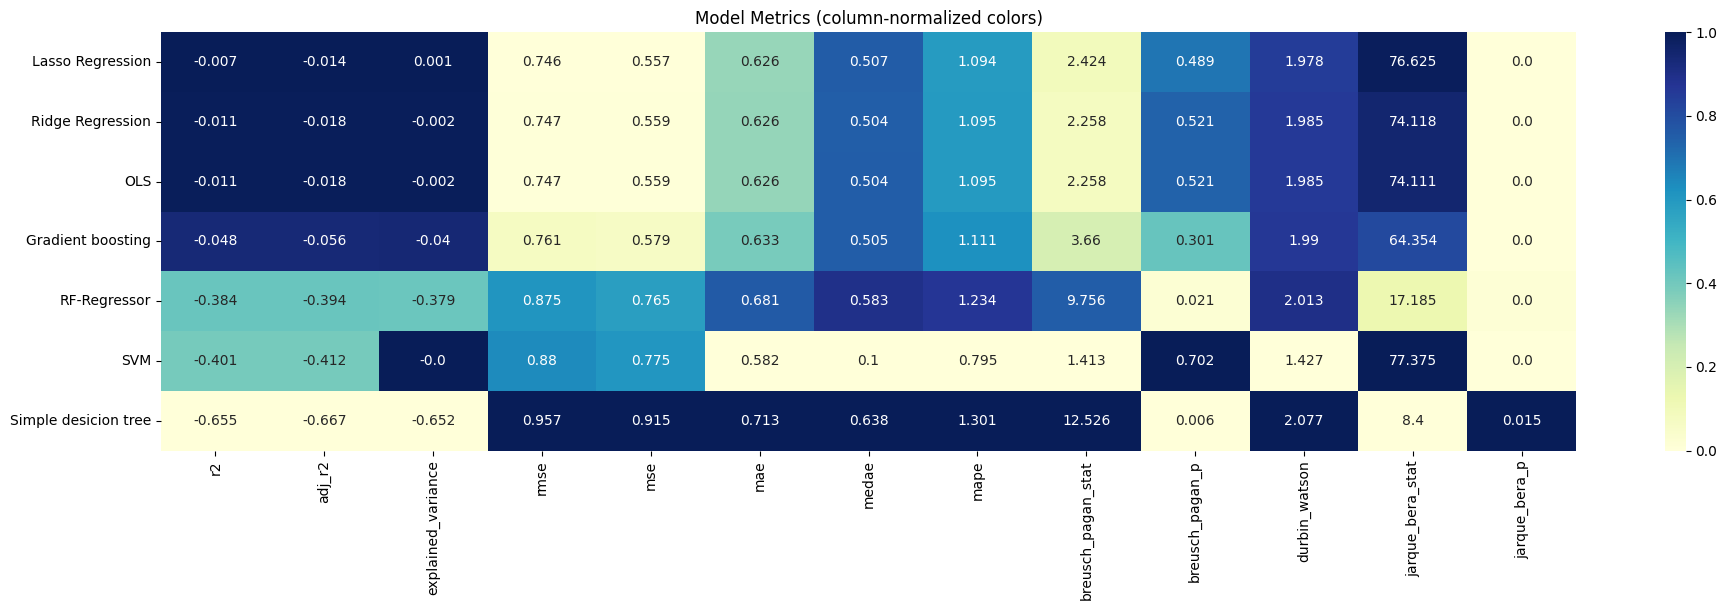

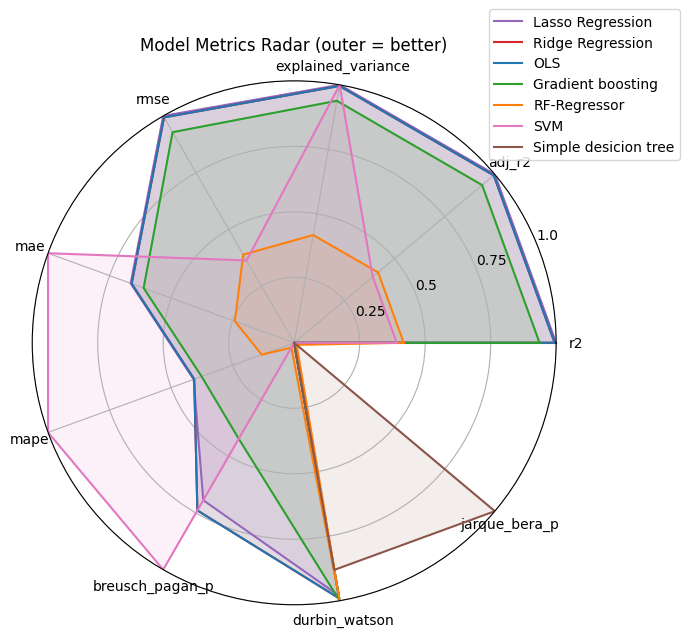

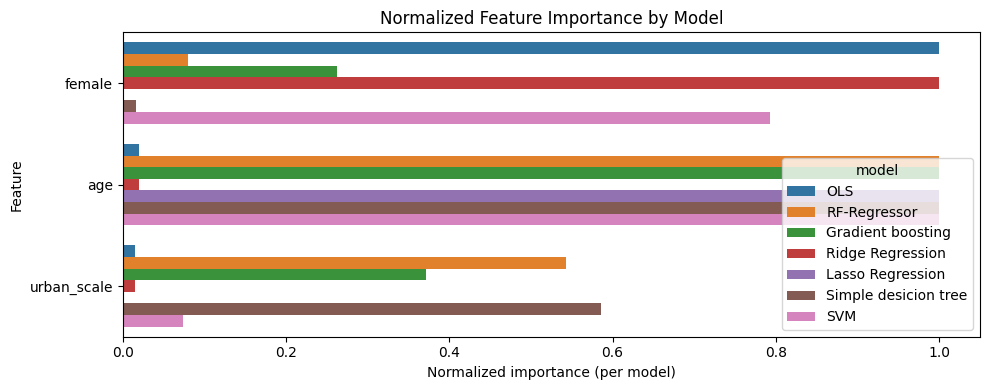

In [61]:
out = regression_evaluation(list(models.items()), X_test, y_test)